# IoT Sensor Dataset — Exploratory Data Analysis (EDA)

This notebook performs EDA on the IoT sensor dataset (temperature, humidity, light, pH, electrical conductivity).
It expects the uploaded ZIP at: `/mnt/data/28667981.zip`.

Objectives:
1. Plot trends and correlations between temperature, humidity, and light.
2. Identify patterns (day–night light cycles, humidity-temperature inverse relation).
3. Compute basic statistics (mean, min, max, variance per sensor).


In [2]:
# Imports & config
import os
import zipfile
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure inline plotting in Jupyter
%matplotlib inline

# Path to the uploaded ZIP (as provided)
ZIP_PATH = '28667981.zip'

# Working folders (relative)
DATA_DIR = 'data'
PLOTS_DIR = 'plots'
OUTPUTS_DIR = 'outputs'

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)

# Extract ZIP if data folder empty
if not any(os.scandir(DATA_DIR)):
    if not os.path.exists(ZIP_PATH):
        raise FileNotFoundError(f"ZIP not found at {ZIP_PATH}. Update ZIP_PATH variable.")
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(DATA_DIR)
    print("Extracted ZIP into", DATA_DIR)
else:
    print("Data directory already populated:", DATA_DIR)

# List CSV files
csv_files = sorted(glob(os.path.join(DATA_DIR, '*.csv')))
print("Found CSV files:", len(csv_files))
if len(csv_files) == 0:
    raise FileNotFoundError("No CSV files found in data/ — check extracted ZIP contents.")


Extracted ZIP into data
Found CSV files: 7


In [3]:
# Load and concatenate daily CSVs
dfs = []
for f in csv_files:
    d = pd.read_csv(f)
    dfs.append(d)
df = pd.concat(dfs, ignore_index=True)

# Basic parsing / housekeeping
if 'timestamp' not in df.columns:
    raise KeyError("Expected 'timestamp' column in CSVs.")

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

# Preview
print("Rows:", len(df))
df.head()


Rows: 120960


,timestamp,temperature,humidity,light,pH,electrical_conductivity,date,hour
0,2025-03-01 00:00:00,24.69,52.66,118.65,6.68,0.996,2025-03-01,0
1,2025-03-01 00:00:05,21.89,50.18,801.71,7.29,1.044,2025-03-01,0
2,2025-03-01 00:00:10,23.88,48.01,682.39,7.66,1.354,2025-03-01,0
3,2025-03-01 00:00:15,20.42,56.73,146.05,7.77,0.519,2025-03-01,0
4,2025-03-01 00:00:20,20.79,41.54,106.87,7.77,1.900,2025-03-01,0


## Trends: time-series plots for Temperature, Humidity, Light


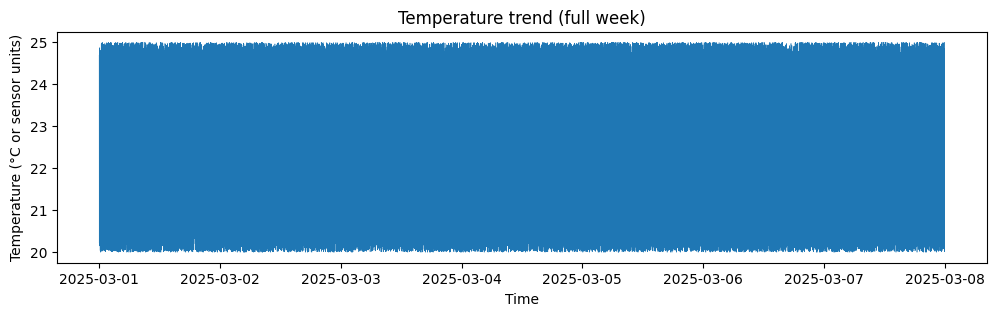

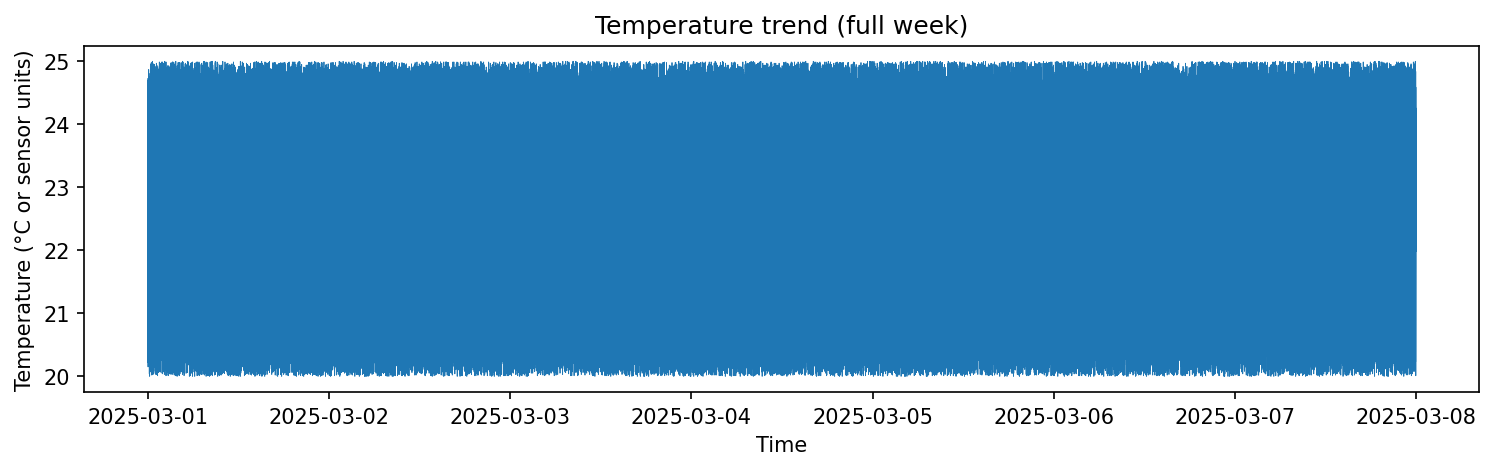

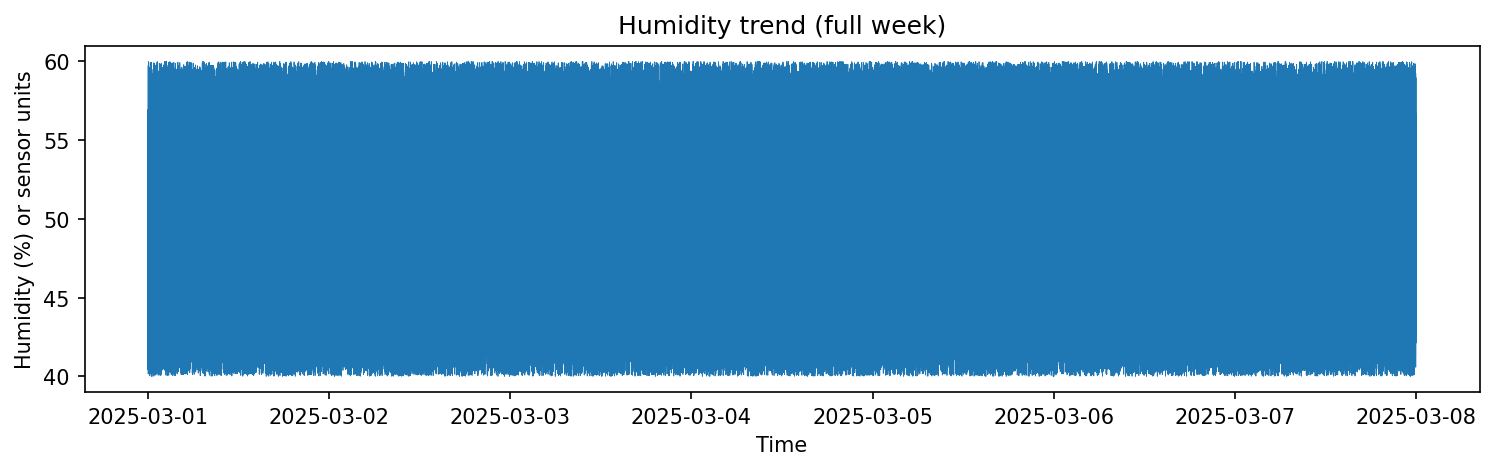

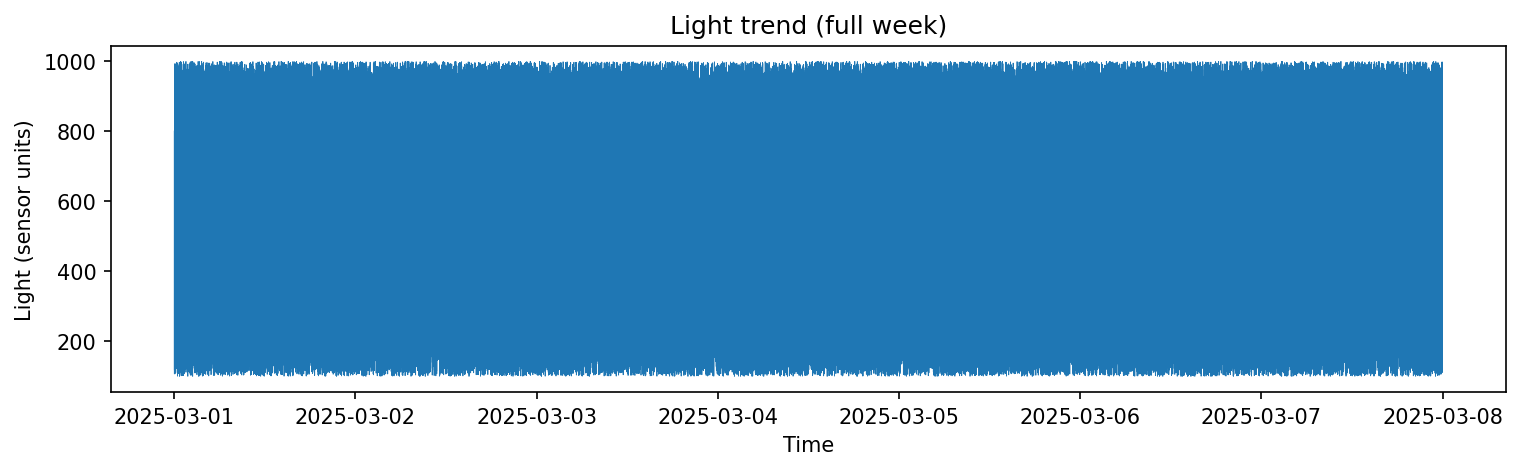

In [4]:
def save_fig(fig, fname):
    path = os.path.join(PLOTS_DIR, fname)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    plt.close(fig)
    return path

# Temperature trend (full week)
fig = plt.figure(figsize=(12,3))
plt.plot(df['timestamp'], df['temperature'], linewidth=0.4)
plt.title("Temperature trend (full week)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C or sensor units)")
save_fig(fig, 'temperature_full_week.png')
display(plt.imread(os.path.join(PLOTS_DIR,'temperature_full_week.png')) if False else fig)  # avoid inline double-plot in some envs

# Humidity trend
fig = plt.figure(figsize=(12,3))
plt.plot(df['timestamp'], df['humidity'], linewidth=0.4)
plt.title("Humidity trend (full week)")
plt.xlabel("Time")
plt.ylabel("Humidity (%) or sensor units")
save_fig(fig, 'humidity_full_week.png')

# Light trend
fig = plt.figure(figsize=(12,3))
plt.plot(df['timestamp'], df['light'], linewidth=0.4)
plt.title("Light trend (full week)")
plt.xlabel("Time")
plt.ylabel("Light (sensor units)")
save_fig(fig, 'light_full_week.png')

# Show thumbnails (display images inline)
from IPython.display import Image, display
display(Image(os.path.join(PLOTS_DIR, 'temperature_full_week.png')))
display(Image(os.path.join(PLOTS_DIR, 'humidity_full_week.png')))
display(Image(os.path.join(PLOTS_DIR, 'light_full_week.png')))


## Correlations & pairwise relationships
We show pairwise scatter plots and a correlation matrix (Pearson).


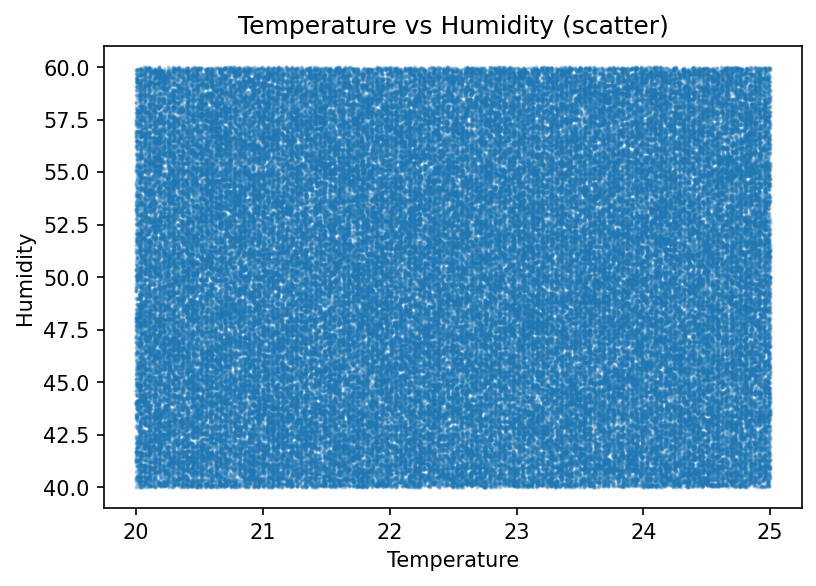

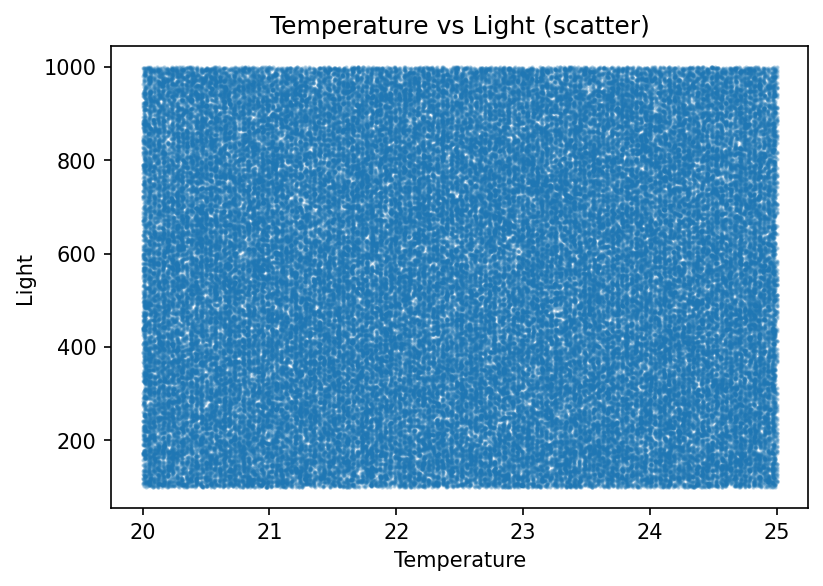

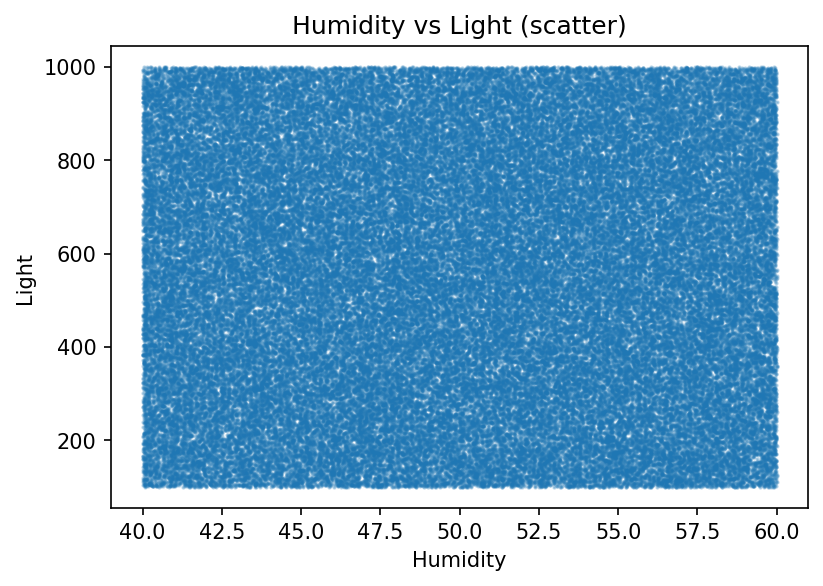

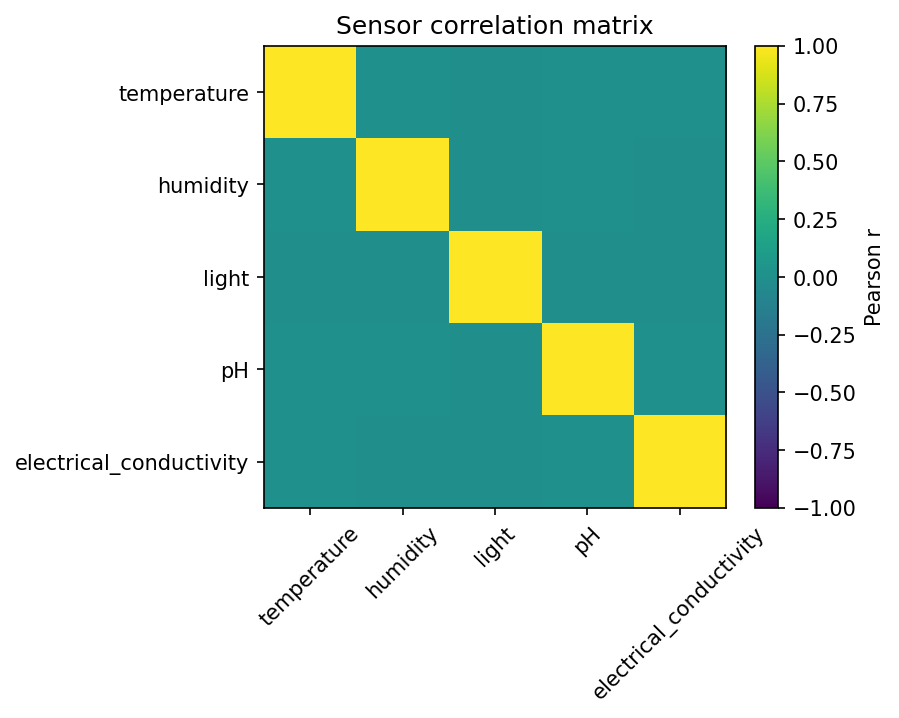

Pearson correlations:


,temperature,humidity,light,pH,electrical_conductivity
temperature,1.000000,0.003655,-0.000423,0.000742,0.003117
humidity,0.003655,1.000000,-0.001196,0.001540,-0.001568
light,-0.000423,-0.001196,1.000000,-0.002546,-0.001242
pH,0.000742,0.001540,-0.002546,1.000000,0.001322
electrical_conductivity,0.003117,-0.001568,-0.001242,0.001322,1.000000


In [5]:
# Pairwise scatter plots
fig = plt.figure(figsize=(6,4))
plt.scatter(df['temperature'], df['humidity'], s=1, alpha=0.3)
plt.title("Temperature vs Humidity (scatter)")
plt.xlabel("Temperature")
plt.ylabel("Humidity")
save_fig(fig, 'scatter_temperature_humidity.png')

fig = plt.figure(figsize=(6,4))
plt.scatter(df['temperature'], df['light'], s=1, alpha=0.3)
plt.title("Temperature vs Light (scatter)")
plt.xlabel("Temperature")
plt.ylabel("Light")
save_fig(fig, 'scatter_temperature_light.png')

fig = plt.figure(figsize=(6,4))
plt.scatter(df['humidity'], df['light'], s=1, alpha=0.3)
plt.title("Humidity vs Light (scatter)")
plt.xlabel("Humidity")
plt.ylabel("Light")
save_fig(fig, 'scatter_humidity_light.png')

# Correlation matrix (Pearson)
sensors = [c for c in ['temperature','humidity','light','pH','electrical_conductivity'] if c in df.columns]
corr = df[sensors].corr(method='pearson')
fig = plt.figure(figsize=(5,4))
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(label='Pearson r')
plt.xticks(range(len(sensors)), sensors, rotation=45)
plt.yticks(range(len(sensors)), sensors)
plt.title("Sensor correlation matrix")
save_fig(fig, 'correlation_matrix.png')

# Display thumbnails
display(Image(os.path.join(PLOTS_DIR, 'scatter_temperature_humidity.png')))
display(Image(os.path.join(PLOTS_DIR, 'scatter_temperature_light.png')))
display(Image(os.path.join(PLOTS_DIR, 'scatter_humidity_light.png')))
display(Image(os.path.join(PLOTS_DIR, 'correlation_matrix.png')))

# Print numeric correlation table
print("Pearson correlations:")
display(corr)


## Day–night pattern: average light by hour
We compute mean light per hour to demonstrate daily cycle.


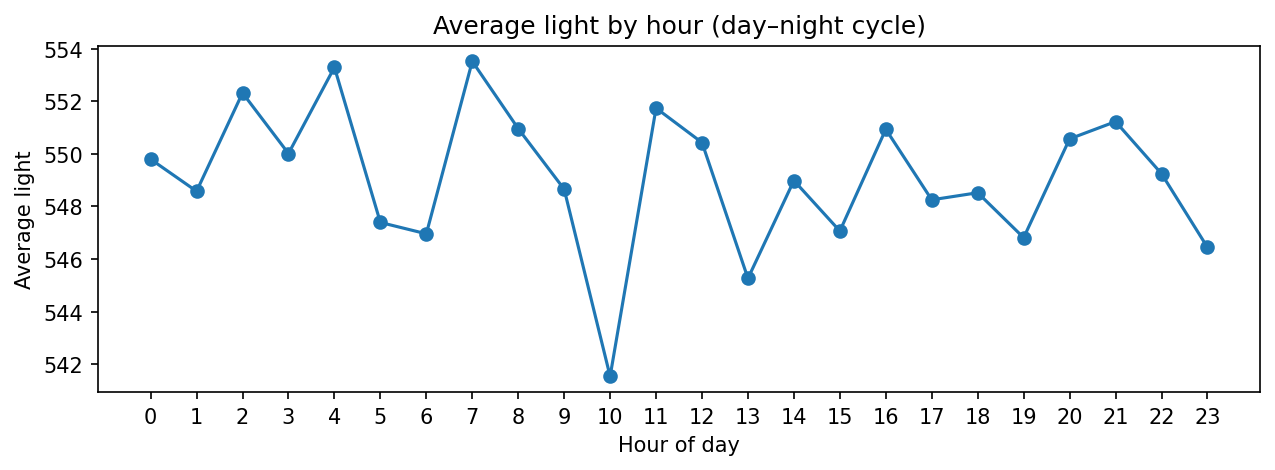

In [6]:
hourly_light = df.groupby('hour')['light'].mean().reindex(range(24)).fillna(0)
fig = plt.figure(figsize=(10,3))
plt.plot(hourly_light.index, hourly_light.values, marker='o')
plt.title("Average light by hour (day–night cycle)")
plt.xlabel("Hour of day")
plt.ylabel("Average light")
plt.xticks(range(0,24))
save_fig(fig, 'avg_light_by_hour.png')
display(Image(os.path.join(PLOTS_DIR, 'avg_light_by_hour.png')))


## Basic statistics (mean, min, max, variance, std, count) per sensor
Saved to `outputs/sensor_stats.csv`.


In [7]:
stats = df[sensors].agg(['mean', 'min', 'max', 'var', 'std']).transpose()
stats['count'] = df[sensors].count().values
stats_path = os.path.join(OUTPUTS_DIR, 'sensor_stats.csv')
stats.to_csv(stats_path)
print("Saved stats to", stats_path)
display(stats)


Saved stats to outputs\sensor_stats.csv


,mean,min,max,var,std,count
temperature,22.500301,20.0,25.00,2.079780,1.442144,120960
humidity,50.026163,40.0,60.00,33.255800,5.766784,120960
light,549.103790,100.0,999.99,67457.729719,259.726259,120960
pH,7.000135,6.0,8.00,0.332774,0.576866,120960
electrical_conductivity,1.249303,0.5,2.00,0.187840,0.433405,120960


## Conclusion & next steps

**Conclusions**
- Day-night cycle for light is visible in `avg_light_by_hour.png`.
- Temperature and humidity show an inverse tendency in portions of data — confirm with correlation matrix.
- Use `outputs/sensor_stats.csv` for numeric summaries.

**Next steps**
- Hourly boxplots to check spread per hour.
- Rolling averages (e.g., 1-minute or 5-minute) to reduce high-frequency noise.
- Anomaly detection (outliers, missing data, sensor dropouts).
- Daily aggregates for reports.
